In [148]:
 # 1 - age (numeric)
 #   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
 #                                       "blue-collar","self-employed","retired","technician","services") 
 #   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
 #   4 - education (categorical: "unknown","secondary","primary","tertiary")
 #   5 - default: has credit in default? (binary: "yes","no")
 #   6 - balance: average yearly balance, in euros (numeric) 
 #   7 - housing: has housing loan? (binary: "yes","no")
 #   8 - loan: has personal loan? (binary: "yes","no")
 #   # related with the last contact of the current campaign:
 #   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
 #  10 - day: last contact day of the month (numeric)
 #  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
 #  12 - duration: last contact duration, in seconds (numeric)
 #   # other attributes:
 #  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
 #  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
 #  15 - previous: number of contacts performed before this campaign and for this client (numeric)
 #  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

 #  Output variable (desired target):
 #  17 - Response - has the client subscribed a term deposit? (binary: "yes","no")



In [149]:
import numpy as  np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score 
from sklearn.metrics import roc_auc_score, roc_curve, multilabel_confusion_matrix
pd.set_option("display.max_columns", None)
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

### 1. Data Gathering

In [150]:
df_res = pd.read_csv("bank-full.csv",sep=";")
df_res.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [151]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [152]:
df_res.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [153]:
df_res.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [154]:
df_res.duplicated().sum()

np.int64(0)

In [155]:
df_res.rename(columns={'y': 'Response'}, inplace=True)
df_res

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Response
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


### 2. Train Test Split

In [156]:
x = df_res.drop("Response", axis =1)
y = df_res["Response"]

In [157]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42, stratify= y)

In [158]:
x_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
24001,36,technician,divorced,secondary,no,861,no,no,telephone,29,aug,140,2,-1,0,unknown
43409,24,student,single,secondary,no,4126,no,no,cellular,5,apr,907,4,185,7,failure
20669,44,technician,single,secondary,no,244,yes,no,cellular,12,aug,1735,4,-1,0,unknown
18810,48,unemployed,married,secondary,no,0,no,no,telephone,31,jul,35,11,-1,0,unknown
23130,38,technician,married,secondary,no,257,no,no,cellular,26,aug,57,10,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17958,50,blue-collar,married,secondary,no,917,yes,no,cellular,30,jul,58,2,-1,0,unknown
15941,36,admin.,single,secondary,no,22,yes,no,cellular,22,jul,77,5,-1,0,unknown
16952,45,blue-collar,married,secondary,no,79,yes,no,cellular,25,jul,98,1,-1,0,unknown
34781,27,management,single,tertiary,no,2559,yes,no,cellular,6,may,227,1,-1,0,unknown


In [159]:
x_test

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
1392,40,blue-collar,married,primary,no,640,yes,yes,unknown,8,may,347,2,-1,0,unknown
7518,44,technician,married,secondary,no,378,yes,no,unknown,30,may,203,2,-1,0,unknown
12007,31,services,married,secondary,no,356,yes,no,unknown,20,jun,228,5,-1,0,unknown
5536,36,blue-collar,married,primary,no,655,yes,no,unknown,23,may,153,4,-1,0,unknown
29816,34,services,single,secondary,no,1921,yes,no,cellular,4,feb,61,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12636,26,blue-collar,single,secondary,no,-333,no,yes,unknown,4,jul,692,1,-1,0,unknown
13364,49,services,married,secondary,no,884,yes,no,telephone,8,jul,201,3,-1,0,unknown
16102,32,entrepreneur,married,tertiary,no,964,yes,no,cellular,22,jul,370,2,-1,0,unknown
42097,20,student,single,primary,no,0,no,no,cellular,2,nov,69,4,182,4,failure


In [160]:
y_train

24001     no
43409    yes
20669    yes
18810     no
23130     no
        ... 
17958     no
15941     no
16952     no
34781     no
44229    yes
Name: Response, Length: 36168, dtype: object

In [161]:
y_test

1392     no
7518     no
12007    no
5536     no
29816    no
         ..
12636    no
13364    no
16102    no
42097    no
31033    no
Name: Response, Length: 9043, dtype: object

### 3. EDA

#### 1. Age

In [162]:
x_train["age"]

24001    36
43409    24
20669    44
18810    48
23130    38
         ..
17958    50
15941    36
16952    45
34781    27
44229    60
Name: age, Length: 36168, dtype: int64

<Axes: xlabel='age', ylabel='Density'>

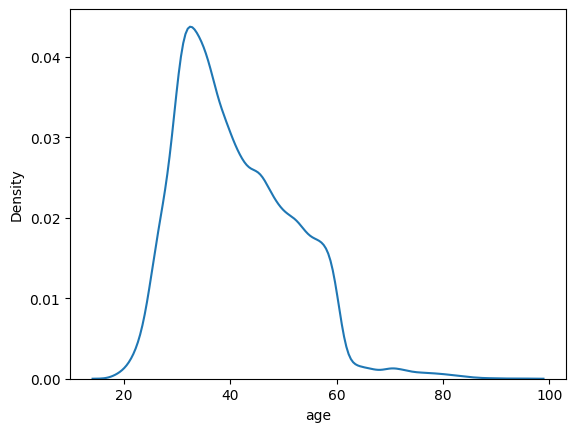

In [163]:
sns.kdeplot(x_train["age"])

<Axes: ylabel='age'>

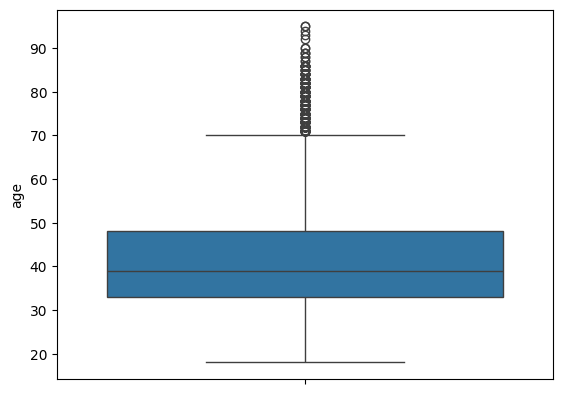

In [164]:
sns.boxplot(x_train["age"])

In [165]:
def impute_outliers(feature):
    q1 = feature.quantile(0.25)
    q2 = feature.quantile(0.5)
    q3 = feature.quantile(0.75)
    
    iqr = q3 - q1
    
    upper_tail = q3 + 1.5 * iqr
    lower_tail = q1 - 1.5 * iqr

    
    feature.loc[feature > upper_tail] = upper_tail
    feature.loc[feature < lower_tail] = lower_tail
    
impute_outliers(x_train['age'])

<Axes: ylabel='age'>

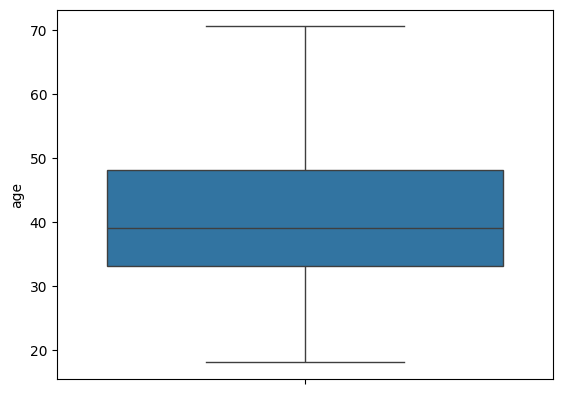

In [166]:
sns.boxplot(x_train["age"])

<Axes: ylabel='age'>

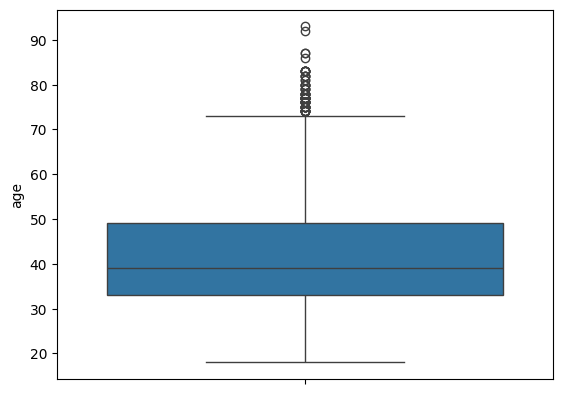

In [167]:
sns.boxplot(x_test["age"])

In [168]:
impute_outliers(x_test["age"])

<Axes: ylabel='age'>

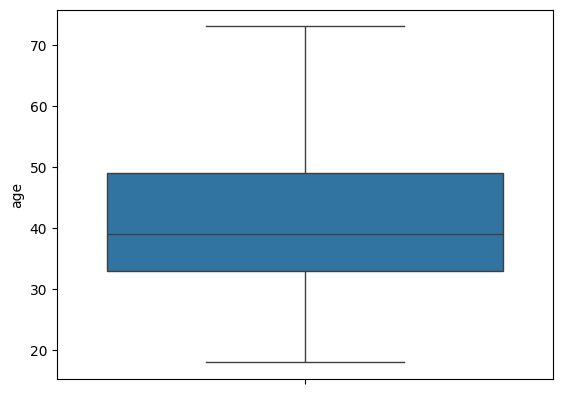

In [169]:
sns.boxplot(x_test["age"])

#### 2. job

In [170]:
x_train['job']

24001     technician
43409        student
20669     technician
18810     unemployed
23130     technician
            ...     
17958    blue-collar
15941         admin.
16952    blue-collar
34781     management
44229         admin.
Name: job, Length: 36168, dtype: object

In [171]:
x_train['job'].value_counts()

job
blue-collar      7830
management       7511
technician       6068
admin.           4141
services         3348
retired          1812
self-employed    1243
entrepreneur     1186
unemployed       1024
housemaid        1013
student           758
unknown           234
Name: count, dtype: int64

In [172]:
x_train = x_train.rename(columns={
    "self-employed ": "self_employed ",
    "blue-collar ": "blue_collar "
})

x_test = x_test.rename(columns={
    "self-employed ": "self_employed ",
    "blue-collar ": "blue_collar "
})

In [173]:
x_train['job'].value_counts()

job
blue-collar      7830
management       7511
technician       6068
admin.           4141
services         3348
retired          1812
self-employed    1243
entrepreneur     1186
unemployed       1024
housemaid        1013
student           758
unknown           234
Name: count, dtype: int64

In [174]:
x_train = pd.get_dummies(x_train, columns=["job"], prefix="job")

# Convert only the dummy columns to int
dummy_cols = [col for col in x_train.columns if col.startswith("job_")]
x_train[dummy_cols] = x_train[dummy_cols].astype(int)

In [175]:
x_train

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
24001,36.0,divorced,secondary,no,861,no,no,telephone,29,aug,140,2,-1,0,unknown,0,0,0,0,0,0,0,0,0,1,0,0
43409,24.0,single,secondary,no,4126,no,no,cellular,5,apr,907,4,185,7,failure,0,0,0,0,0,0,0,0,1,0,0,0
20669,44.0,single,secondary,no,244,yes,no,cellular,12,aug,1735,4,-1,0,unknown,0,0,0,0,0,0,0,0,0,1,0,0
18810,48.0,married,secondary,no,0,no,no,telephone,31,jul,35,11,-1,0,unknown,0,0,0,0,0,0,0,0,0,0,1,0
23130,38.0,married,secondary,no,257,no,no,cellular,26,aug,57,10,-1,0,unknown,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17958,50.0,married,secondary,no,917,yes,no,cellular,30,jul,58,2,-1,0,unknown,0,1,0,0,0,0,0,0,0,0,0,0
15941,36.0,single,secondary,no,22,yes,no,cellular,22,jul,77,5,-1,0,unknown,1,0,0,0,0,0,0,0,0,0,0,0
16952,45.0,married,secondary,no,79,yes,no,cellular,25,jul,98,1,-1,0,unknown,0,1,0,0,0,0,0,0,0,0,0,0
34781,27.0,single,tertiary,no,2559,yes,no,cellular,6,may,227,1,-1,0,unknown,0,0,0,0,1,0,0,0,0,0,0,0


In [176]:
x_test = pd.get_dummies(x_test, columns=["job"], prefix="job")

# Convert only the dummy columns to int
dummy_cols = [col for col in x_test.columns if col.startswith("job_")]
x_test[dummy_cols] = x_test[dummy_cols].astype(int)

In [177]:
x_train = x_train.rename(columns={
    "job_blue-collar": "job_blue_collar",
    "job_self-employed ": "job_self_employed "
})

x_test = x_test.rename(columns={
     "job_blue-collar": "job_blue_collar",
    "job_self-employed ": "job_self_employed "
})

In [178]:
x_test

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,job_admin.,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
1392,40,married,primary,no,640,yes,yes,unknown,8,may,347,2,-1,0,unknown,0,1,0,0,0,0,0,0,0,0,0,0
7518,44,married,secondary,no,378,yes,no,unknown,30,may,203,2,-1,0,unknown,0,0,0,0,0,0,0,0,0,1,0,0
12007,31,married,secondary,no,356,yes,no,unknown,20,jun,228,5,-1,0,unknown,0,0,0,0,0,0,0,1,0,0,0,0
5536,36,married,primary,no,655,yes,no,unknown,23,may,153,4,-1,0,unknown,0,1,0,0,0,0,0,0,0,0,0,0
29816,34,single,secondary,no,1921,yes,no,cellular,4,feb,61,1,-1,0,unknown,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12636,26,single,secondary,no,-333,no,yes,unknown,4,jul,692,1,-1,0,unknown,0,1,0,0,0,0,0,0,0,0,0,0
13364,49,married,secondary,no,884,yes,no,telephone,8,jul,201,3,-1,0,unknown,0,0,0,0,0,0,0,1,0,0,0,0
16102,32,married,tertiary,no,964,yes,no,cellular,22,jul,370,2,-1,0,unknown,0,0,1,0,0,0,0,0,0,0,0,0
42097,20,single,primary,no,0,no,no,cellular,2,nov,69,4,182,4,failure,0,0,0,0,0,0,0,0,1,0,0,0


#### 3. marital

In [179]:
x_train['marital'].value_counts()

marital
married     21771
single      10227
divorced     4170
Name: count, dtype: int64

In [180]:
val = {
    "married":0,
    "single":1,
    "divorced":2
}

x_train['marital'] = x_train['marital'].map(val)

In [181]:
x_train['marital']

24001    2
43409    1
20669    1
18810    0
23130    0
        ..
17958    0
15941    1
16952    0
34781    1
44229    0
Name: marital, Length: 36168, dtype: int64

In [182]:
val = {
    "married":0,
    "single":1,
    "divorced":2
}

x_test['marital'] = x_test['marital'].map(val)

In [183]:
x_test['marital']

1392     0
7518     0
12007    0
5536     0
29816    1
        ..
12636    1
13364    0
16102    0
42097    1
31033    0
Name: marital, Length: 9043, dtype: int64

#### 4. education

In [184]:
x_train["education"].value_counts()

education
secondary    18561
tertiary     10594
primary       5531
unknown       1482
Name: count, dtype: int64

In [185]:
edu = {
    "secondary": 0,
    "tertiary": 1,
    "primary": 2,
    "unknown": 3
}
x_train["education"] = x_train["education"].map(edu)

In [186]:
x_train["education"]

24001    0
43409    0
20669    0
18810    0
23130    0
        ..
17958    0
15941    0
16952    0
34781    1
44229    3
Name: education, Length: 36168, dtype: int64

In [187]:
edu = {
    "secondary": 0,
    "tertiary": 1,
    "primary": 2,
    "unknown": 3
}
x_test["education"] = x_test["education"].map(edu)

In [188]:
x_test["education"] 

1392     2
7518     0
12007    0
5536     2
29816    0
        ..
12636    0
13364    0
16102    1
42097    2
31033    0
Name: education, Length: 9043, dtype: int64

#### 5. default

In [189]:
x_train["default"].value_counts()

default
no     35521
yes      647
Name: count, dtype: int64

In [190]:
deft = {
    "no":0,
    "yes":1
}

x_train["default"] = x_train["default"].map(deft)

In [191]:
x_train["default"]

24001    0
43409    0
20669    0
18810    0
23130    0
        ..
17958    0
15941    0
16952    0
34781    0
44229    0
Name: default, Length: 36168, dtype: int64

In [192]:
deft = {
    "no":0,
    "yes":1
}

x_test["default"] = x_test["default"].map(deft)

In [193]:
x_test["default"] 

1392     0
7518     0
12007    0
5536     0
29816    0
        ..
12636    0
13364    0
16102    0
42097    0
31033    0
Name: default, Length: 9043, dtype: int64

#### 6. balance

In [194]:
x_train["balance"]

24001     861
43409    4126
20669     244
18810       0
23130     257
         ... 
17958     917
15941      22
16952      79
34781    2559
44229     478
Name: balance, Length: 36168, dtype: int64

<Axes: xlabel='balance', ylabel='Density'>

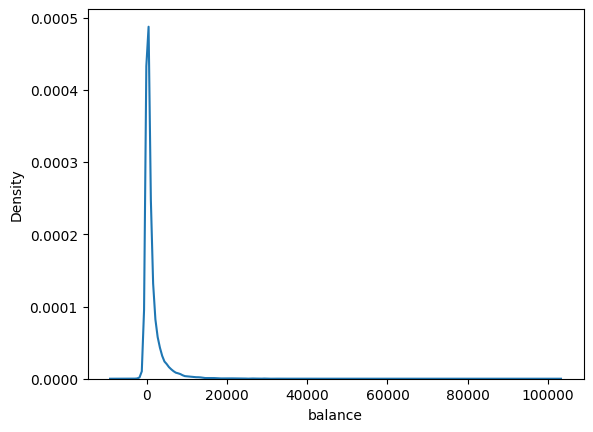

In [195]:
sns.kdeplot(x_train["balance"])

<Axes: ylabel='balance'>

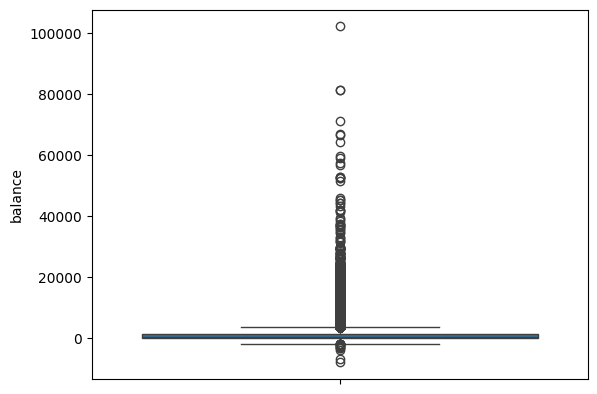

In [196]:
sns.boxplot(x_train["balance"])

In [197]:
def impute_outliers(feature):
    q1 = feature.quantile(0.25)
    q2 = feature.quantile(0.5)
    q3 = feature.quantile(0.75)
    
    iqr = q3 - q1
    
    upper_tail = q3 + 1.5 * iqr
    lower_tail = q1 - 1.5 * iqr

    
    feature.loc[feature > upper_tail] = upper_tail
    feature.loc[feature < lower_tail] = lower_tail
    
impute_outliers(x_train['balance'])

<Axes: ylabel='balance'>

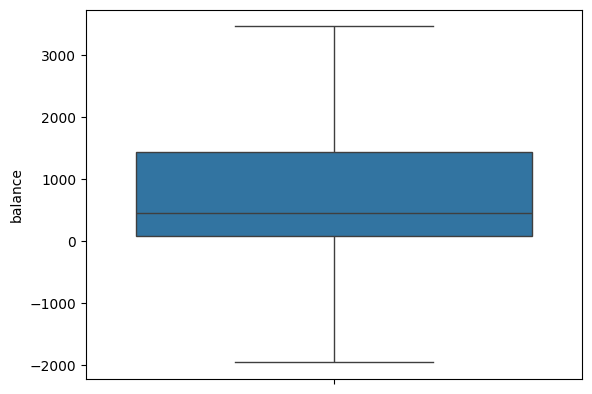

In [198]:
sns.boxplot(x_train["balance"])

In [199]:
impute_outliers(x_test['balance'])

<Axes: ylabel='balance'>

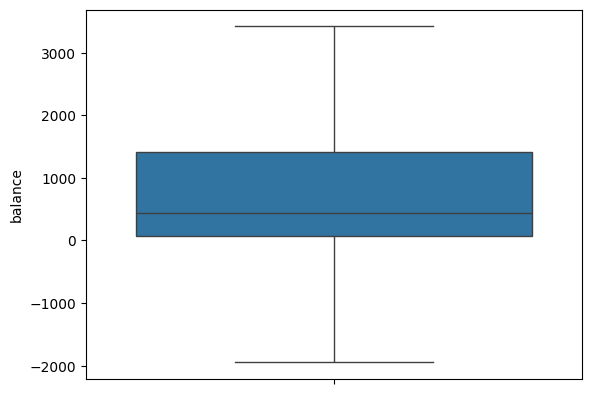

In [200]:
sns.boxplot(x_test["balance"])

#### 7. housing

In [201]:
x_train["housing"].value_counts()

housing
yes    20182
no     15986
Name: count, dtype: int64

In [202]:
deft = {
    "no":0,
    "yes":1
}

x_train["housing"] = x_train["housing"].map(deft)

In [203]:
x_train["housing"]

24001    0
43409    0
20669    1
18810    0
23130    0
        ..
17958    1
15941    1
16952    1
34781    1
44229    0
Name: housing, Length: 36168, dtype: int64

In [204]:
deft = {
    "no":0,
    "yes":1
}

x_test["housing"] = x_test["housing"].map(deft)

In [205]:
x_test["housing"]

1392     1
7518     1
12007    1
5536     1
29816    1
        ..
12636    0
13364    1
16102    1
42097    0
31033    1
Name: housing, Length: 9043, dtype: int64

#### 8. loan

In [206]:
x_train['loan'].value_counts()

loan
no     30355
yes     5813
Name: count, dtype: int64

In [207]:
lo = {
    "no":0,
    "yes":1
}

x_train["loan"] = x_train["loan"].map(lo)
x_test["loan"] = x_test["loan"].map(lo)

In [208]:
x_train["loan"]

24001    0
43409    0
20669    0
18810    0
23130    0
        ..
17958    0
15941    0
16952    0
34781    0
44229    0
Name: loan, Length: 36168, dtype: int64

In [209]:
x_test["loan"]

1392     1
7518     0
12007    0
5536     0
29816    0
        ..
12636    1
13364    0
16102    0
42097    0
31033    1
Name: loan, Length: 9043, dtype: int64

#### 9. contact

In [210]:
x_train['contact'].value_counts()

contact
cellular     23465
unknown      10386
telephone     2317
Name: count, dtype: int64

In [211]:
cont = {
    "cellular":0,
    "unknown":1,
    "telephone":2
}

x_train['contact'] = x_train['contact'].map(cont)
x_test['contact'] = x_test['contact'].map(cont)

In [212]:
x_train['contact']

24001    2
43409    0
20669    0
18810    2
23130    0
        ..
17958    0
15941    0
16952    0
34781    0
44229    0
Name: contact, Length: 36168, dtype: int64

In [213]:
x_test['contact']

1392     1
7518     1
12007    1
5536     1
29816    0
        ..
12636    1
13364    2
16102    0
42097    0
31033    0
Name: contact, Length: 9043, dtype: int64

#### 10. day

In [214]:
x_train['day']

24001    29
43409     5
20669    12
18810    31
23130    26
         ..
17958    30
15941    22
16952    25
34781     6
44229    19
Name: day, Length: 36168, dtype: int64

<Axes: ylabel='day'>

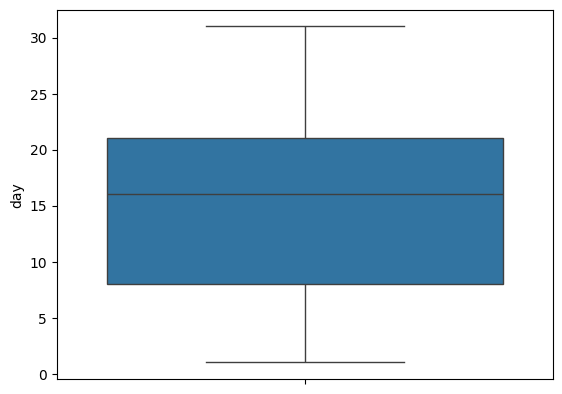

In [215]:
sns.boxplot(x_train['day'])

<Axes: xlabel='day', ylabel='Density'>

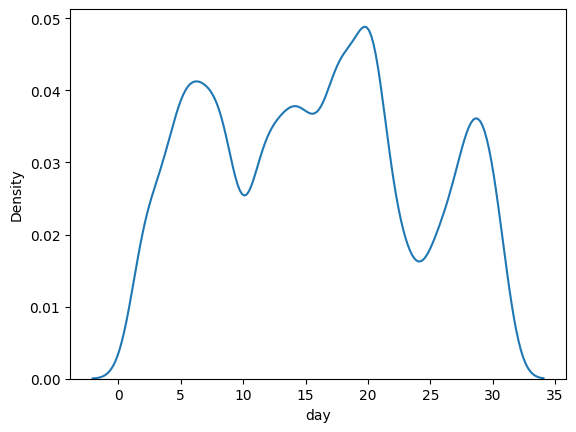

In [216]:
sns.kdeplot(x_train['day'])

#### 11. month

In [217]:
x_train["month"].value_counts()

month
may    11062
jul     5537
aug     4986
jun     4237
nov     3143
apr     2394
feb     2078
jan     1119
oct      592
sep      451
mar      391
dec      178
Name: count, dtype: int64

In [218]:
mon = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dec": 12
}

x_train["month"] = x_train["month"].map(mon)
x_test["month"] = x_test["month"].map(mon)

In [219]:
x_train["month"]

24001    8
43409    4
20669    8
18810    7
23130    8
        ..
17958    7
15941    7
16952    7
34781    5
44229    7
Name: month, Length: 36168, dtype: int64

In [220]:
x_test["month"]

1392      5
7518      5
12007     6
5536      5
29816     2
         ..
12636     7
13364     7
16102     7
42097    11
31033     2
Name: month, Length: 9043, dtype: int64

#### 12. duration

In [221]:
x_train["duration"]

24001     140
43409     907
20669    1735
18810      35
23130      57
         ... 
17958      58
15941      77
16952      98
34781     227
44229     173
Name: duration, Length: 36168, dtype: int64

<Axes: ylabel='duration'>

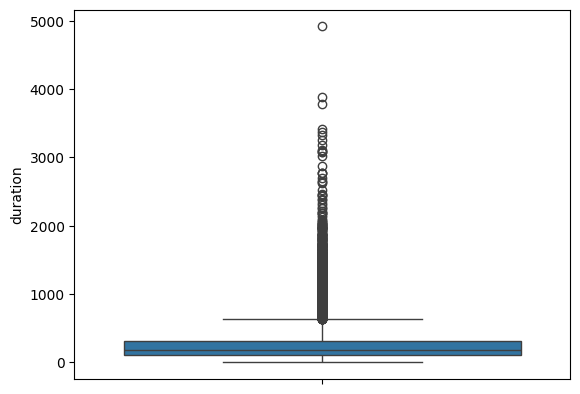

In [222]:
sns.boxplot(x_train["duration"])

In [223]:
impute_outliers(x_train['duration'])
impute_outliers(x_test['duration'])

<Axes: ylabel='duration'>

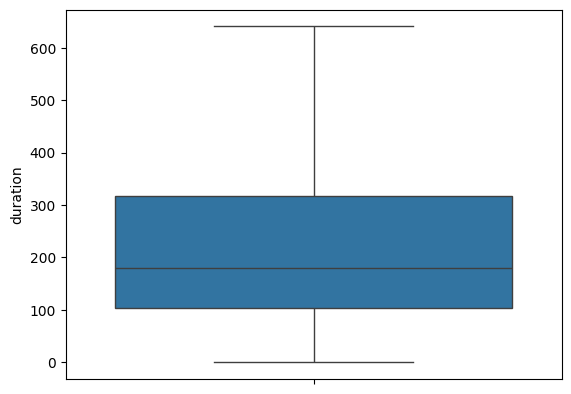

In [224]:
sns.boxplot(x_train["duration"])

<Axes: ylabel='duration'>

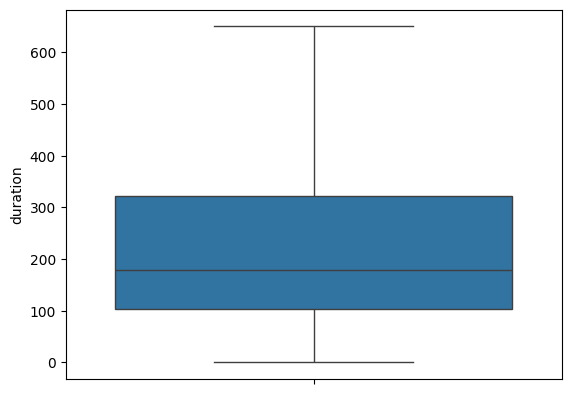

In [225]:
sns.boxplot(x_test["duration"])

#### 13. campaign

In [226]:
x_train["campaign"]

24001     2
43409     4
20669     4
18810    11
23130    10
         ..
17958     2
15941     5
16952     1
34781     1
44229     2
Name: campaign, Length: 36168, dtype: int64

<Axes: ylabel='campaign'>

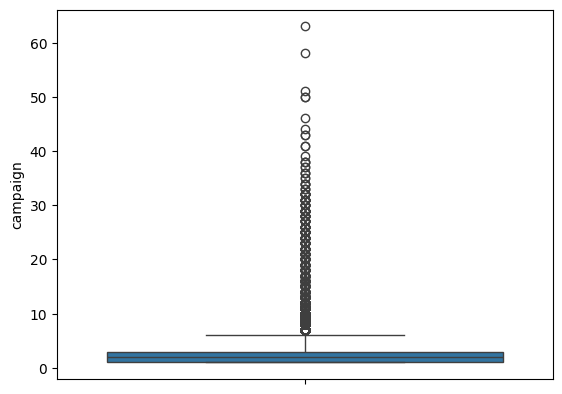

In [227]:
sns.boxplot(x_train["campaign"])

In [228]:
impute_outliers(x_train["campaign"])
impute_outliers(x_test["campaign"])

<Axes: xlabel='campaign', ylabel='Density'>

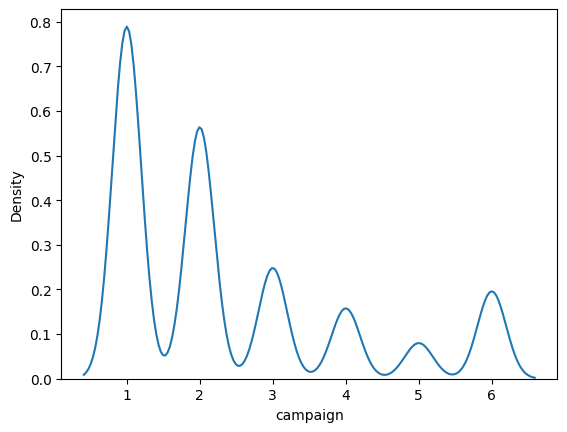

In [229]:
sns.kdeplot(x_train["campaign"])

<Axes: xlabel='campaign', ylabel='Density'>

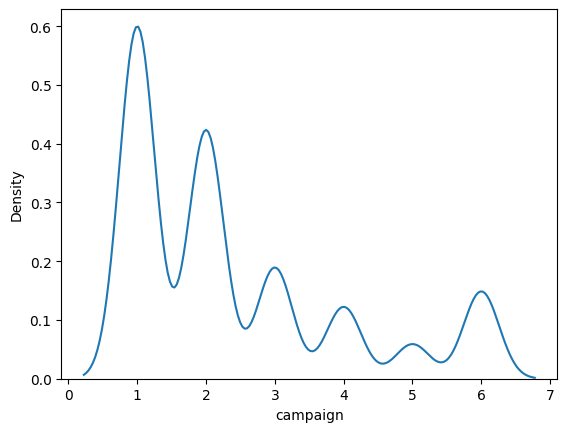

In [230]:
sns.kdeplot(x_test["campaign"])

### 14. pdays

In [231]:
x_train["pdays"]

24001     -1
43409    185
20669     -1
18810     -1
23130     -1
        ... 
17958     -1
15941     -1
16952     -1
34781     -1
44229    311
Name: pdays, Length: 36168, dtype: int64

<Axes: ylabel='pdays'>

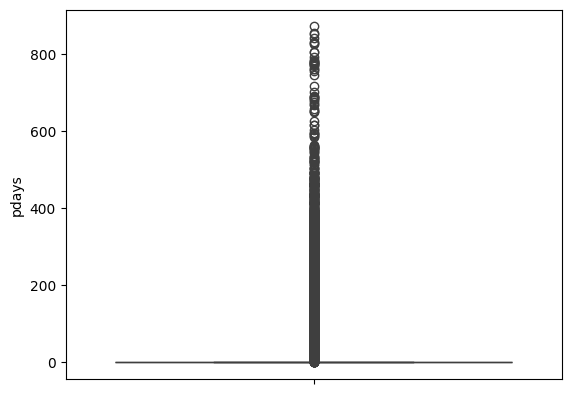

In [232]:
sns.boxplot(x_train["pdays"])

#### 15. previous

In [233]:
x_train["previous"]

24001    0
43409    7
20669    0
18810    0
23130    0
        ..
17958    0
15941    0
16952    0
34781    0
44229    8
Name: previous, Length: 36168, dtype: int64

<Axes: ylabel='previous'>

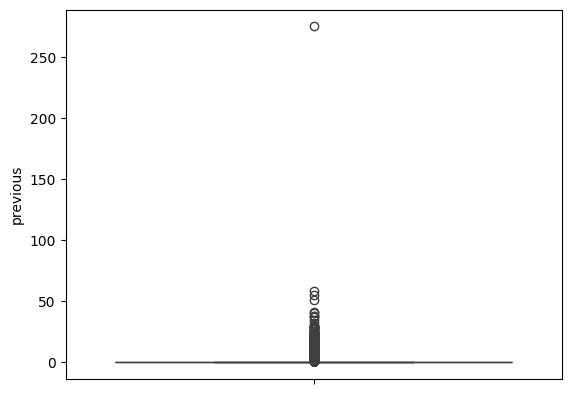

In [234]:
sns.boxplot(x_train["previous"])

#### 16. poutcome

In [235]:
x_train["poutcome"].value_counts()

poutcome
unknown    29589
failure     3889
other       1485
success     1205
Name: count, dtype: int64

In [236]:
val ={
    "unknown":0,
    "failure":1,
    "other":2,
    "success":3
}

x_train["poutcome"] = x_train["poutcome"].map(val)
x_test["poutcome"] = x_test["poutcome"].map(val)

In [237]:
x_train["poutcome"]

24001    0
43409    1
20669    0
18810    0
23130    0
        ..
17958    0
15941    0
16952    0
34781    0
44229    1
Name: poutcome, Length: 36168, dtype: int64

In [238]:
x_test["poutcome"]

1392     0
7518     0
12007    0
5536     0
29816    0
        ..
12636    0
13364    0
16102    0
42097    1
31033    1
Name: poutcome, Length: 9043, dtype: int64

#### 17. Target

In [239]:
y_train

24001     no
43409    yes
20669    yes
18810     no
23130     no
        ... 
17958     no
15941     no
16952     no
34781     no
44229    yes
Name: Response, Length: 36168, dtype: object

In [240]:
tar = {
    "no":0,
    "yes":1
}
y_train = y_train.map(tar)

In [241]:
y_train

24001    0
43409    1
20669    1
18810    0
23130    0
        ..
17958    0
15941    0
16952    0
34781    0
44229    1
Name: Response, Length: 36168, dtype: int64

In [242]:
y_test

1392     no
7518     no
12007    no
5536     no
29816    no
         ..
12636    no
13364    no
16102    no
42097    no
31033    no
Name: Response, Length: 9043, dtype: object

In [243]:
tar = {
    "no":0,
    "yes":1
}
y_test = y_test.map(tar)

In [244]:
y_test

1392     0
7518     0
12007    0
5536     0
29816    0
        ..
12636    0
13364    0
16102    0
42097    0
31033    0
Name: Response, Length: 9043, dtype: int64

In [245]:
!pip install imbalanced-learn


Response
0    31937
1    31937
Name: count, dtype: int64
Response
0    0.5
1    0.5
Name: proportion, dtype: float64


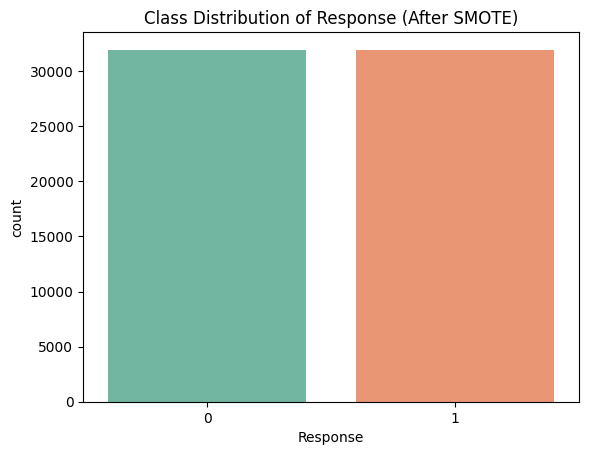

In [246]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Apply SMOTE
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)

# Create a new dataframe for visualization
df_res = pd.DataFrame(x_train_res, columns=x_train.columns)
df_res["Response"] = y_train_res

# Check counts
print(df_res['Response'].value_counts())
print(df_res['Response'].value_counts(normalize=True))  # percentage

# Plot class distribution
sns.countplot(x='Response', data=df_res, palette='Set2')
plt.title("Class Distribution of Response (After SMOTE)")
plt.show()


### Model Traning

In [247]:
# log_clf = LogisticRegression()
# log_clf.fit(x_train_res, y_train_res)

In [248]:
# def evaluation(string,model, ind_var, act):
#     print(string.center(50,'*'))
#     pred = model.predict(ind_var)

#     acc_score = accuracy_score(act, pred)
#     print('Accuracy Score :', acc_score)
#     print('**'*20)

#     cnf_matrix = confusion_matrix(act, pred)
#     print('Confusion Matrix :\n', cnf_matrix)
#     print('**'*20)

#     clf_report = classification_report(act, pred)
#     print('Classification Report :\n', clf_report)
#     print('**'*20)

#     return pred

# y_pred_train = evaluation('Train Data Evaluation', log_clf, x_train, y_train)

In [249]:
# y_pred_test = evaluation('Test Data Evaluation', log_clf, x_test, y_test)

### Hyperparameter Tuning

In [250]:
# from sklearn.model_selection import RandomizedSearchCV
# param_grid = {
#     'penalty': ['l1', 'l2', 'elasticnet', None],   # types of regularization
#     'C': np.logspace(-3, 3, 100),                  # inverse of regularization strength
#     'solver': ['lbfgs', 'liblinear', 'saga'],      # solvers
#     'l1_ratio': np.linspace(0, 1, 10)              # used only if penalty='elasticnet'
# }

# rscv_log_reg = RandomizedSearchCV(log_clf,param_distributions=param_grid,cv=3,scoring='recall',n_iter=30,random_state=11,n_jobs=-1)

# rscv_log_reg.fit(x_train_res, y_train_res)

# print(rscv_log_reg.best_estimator_)
# print(rscv_log_reg.best_params_)

In [251]:
# hyp_clf=rscv_log_reg.best_estimator_
# hyp_clf.fit(x_train_res, y_train_res)

In [252]:
# train = evaluation('Test Data Evaluation', hyp_clf, x_train_res, y_train_res)
# test = evaluation('Test Data Evaluation', hyp_clf, x_train_res, y_train_res)

### AUC ROC Curve

In [253]:
# y_pred_proba = hyp_clf.predict_proba(x_test)
# y_pred_proba

In [254]:
# fpr , tpr, thresh = roc_curve(y_test, y_pred_proba[:, 1])
# fpr

In [255]:
# tpr

In [256]:
# thresh

In [257]:
# plt.title('ROC Curve')
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positve Rate')

In [258]:
# auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
# auc_score

In [259]:
# value_pred = []

# for i in y_pred_proba[:,1]:
#     if i>=0.6:
#         value_pred.append(1)
#     else:
#         value_pred.append(0)

In [260]:
# arr = np.array(value_pred)

# confusion_matrix(y_test, arr)

In [261]:
# print(classification_report(y_test, arr))

In [262]:
x_test.head(1)

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,job_admin.,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
1392,40,0,2,0,640.0,1,1,1,8,5,347.0,2,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [263]:
age = 40
marital = 0
education = 2
default = 0
balance = 640.0
housing = 1
loan = 1
contact = 1
day = 8
month = 5
duration = 347.0
campaign = 2
pdays = -1
previous = 0
poutcome = 0
job_admin = 0
job_blue_collar	= 1
job_entrepreneur = 0
job_housemaid = 0
job_management = 0
job_retired = 0
job_self_employed = 0
job_services =0
job_student = 0
job_technician = 0
job_unemployed = 0
job_unknown = 0



In [264]:
# x_train.columns

In [265]:
# test_array = np.array([age, marital, education, default, balance, housing, loan,
#        contact, day, month, duration, campaign, pdays, previous,
#        poutcome, job_admin, job_blue-collar, job_entrepreneur,
#        job_housemaid, job_management, job_retired, job_self-employed,
#        job_services, job_student, job_technician, job_unemployed,
#        job_unknown])

In [266]:
# result = hyp_clf.predict_proba([test_array])

In [267]:
x_train.columns

Index(['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'job_admin.', 'job_blue_collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown'],
      dtype='object')

In [268]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Example: using numeric features from your dataset
num_features = ['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'job_admin.', 'job_blue_collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown']

X = x_train[num_features]

# Add constant for statsmodels
X_const = add_constant(X)

# Calculate VIF
vif = pd.DataFrame()
vif["Feature"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) 
              for i in range(X_const.shape[1])]

print(vif)

              Feature       VIF
0               const  0.000000
1                 age  1.413979
2             marital  1.046895
3           education  1.176340
4             default  1.023247
5             balance  1.071062
6             housing  1.174876
7                loan  1.036140
8             contact  1.105971
9                 day  1.041049
10              month  1.095238
11           duration  1.019922
12           campaign  1.053910
13              pdays  2.193861
14           previous  1.321188
15           poutcome  2.223111
16         job_admin.       inf
17    job_blue_collar       inf
18   job_entrepreneur       inf
19      job_housemaid       inf
20     job_management       inf
21        job_retired       inf
22  job_self-employed       inf
23       job_services       inf
24        job_student       inf
25     job_technician       inf
26     job_unemployed       inf
27        job_unknown       inf


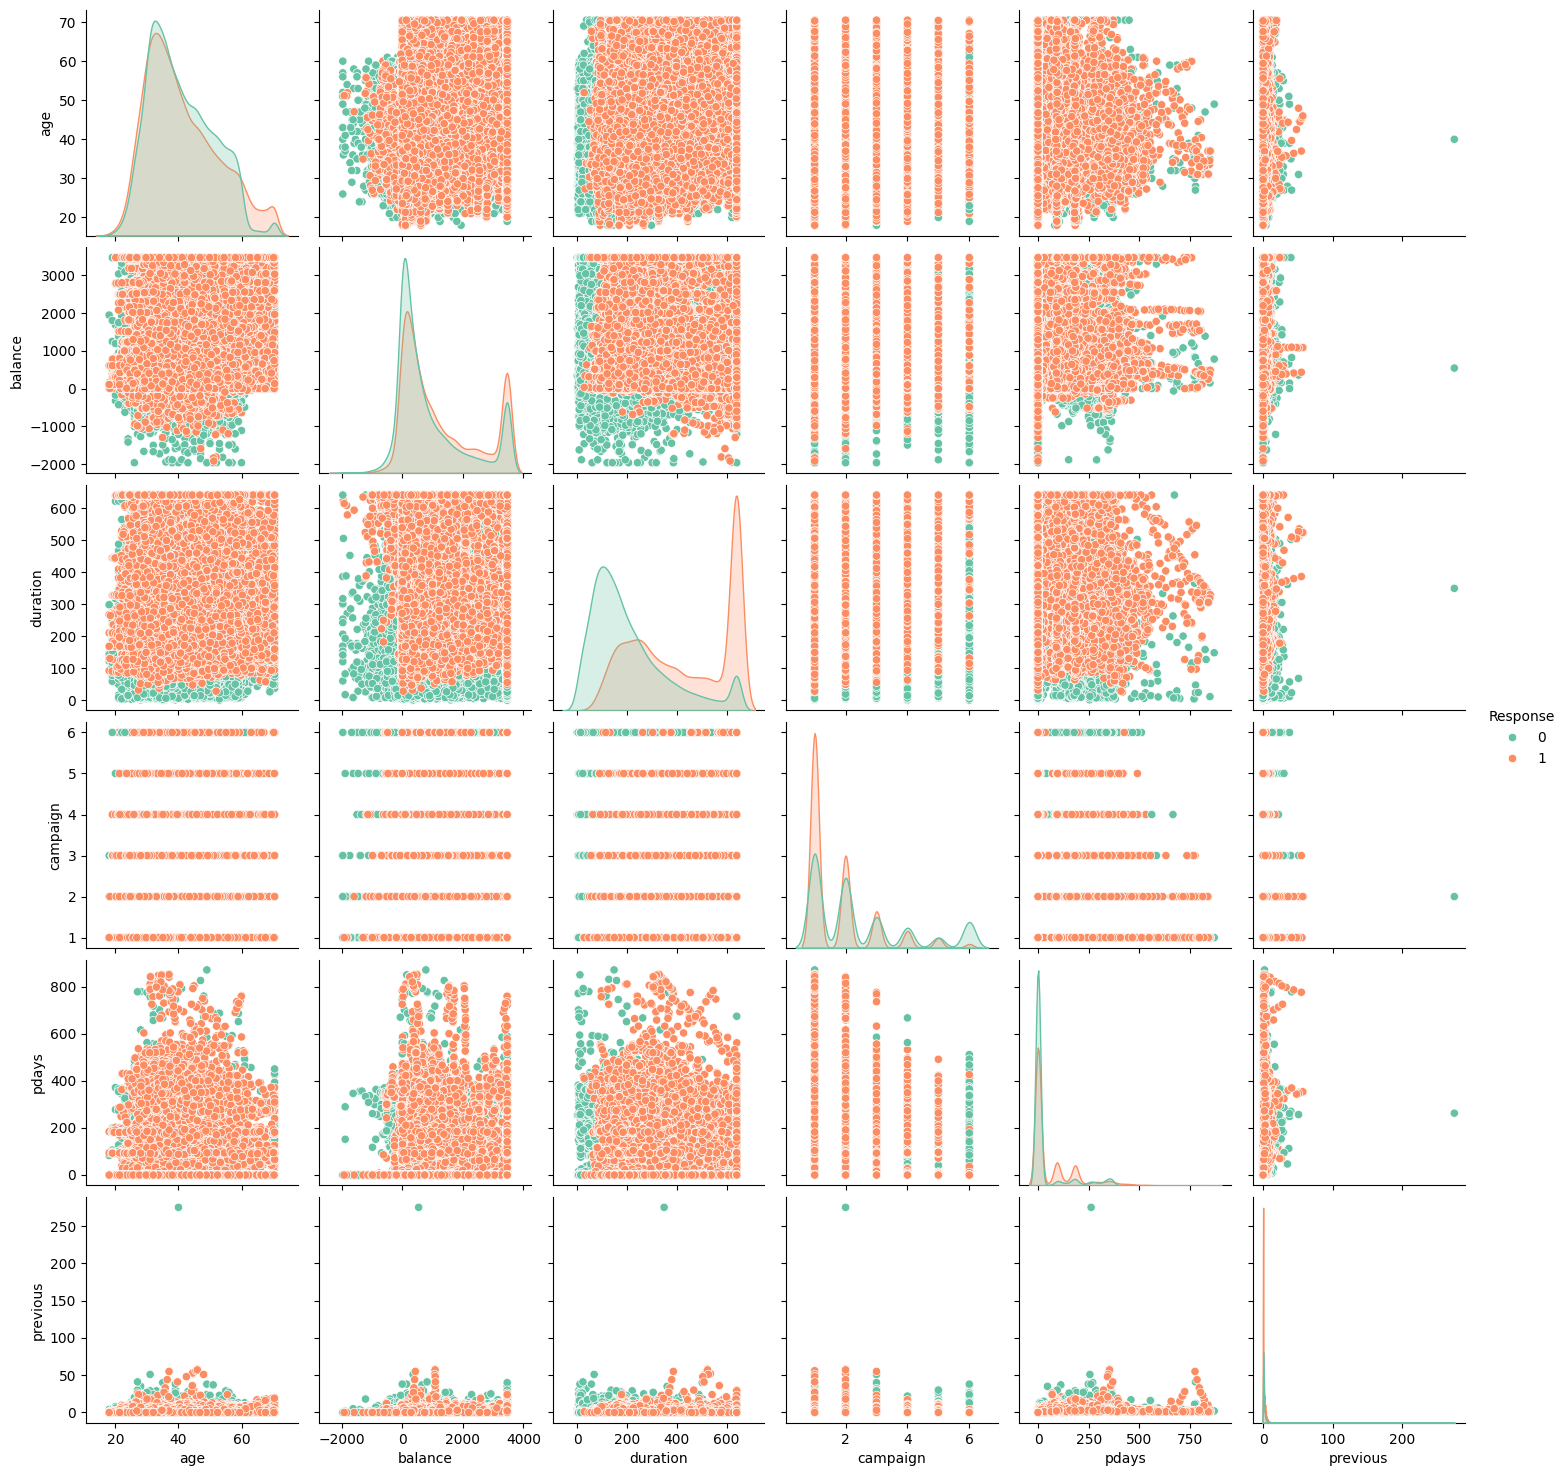

In [269]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only a subset of numeric columns (pairplot works best this way)
num_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]

# Pairplot with hue = target (y column in your dataset)
sns.pairplot(df_res[num_cols + ["Response"]], hue="Response", diag_kind="kde", palette="Set2")

plt.show()

In [270]:
# y_test

Response
0    31937
1    31937
Name: count, dtype: int64
Response
0    0.5
1    0.5
Name: proportion, dtype: float64


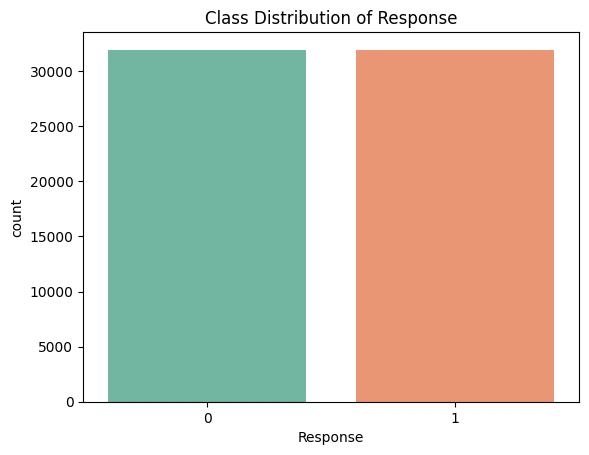

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check counts
print(df_res['Response'].value_counts())
print(df_res['Response'].value_counts(normalize=True))  # percentage

# Plot class distribution
sns.countplot(x='Response', data=df_res, palette='Set2')
plt.title("Class Distribution of Response")
plt.show()

In [272]:
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=None)

# # Train the model on balanced data
# rf.fit(x_train_res, y_train_res)

In [273]:
# def evaluation(string,model, ind_var, act):
#     print(string.center(50,'*'))
#     pred = model.predict(ind_var)

#     acc_score = accuracy_score(act, pred)
#     print('Accuracy Score :', acc_score)
#     print('**'*20)

#     cnf_matrix = confusion_matrix(act, pred)
#     print('Confusion Matrix :\n', cnf_matrix)
#     print('**'*20)

#     clf_report = classification_report(act, pred)
#     print('Classification Report :\n', clf_report)
#     print('**'*20)

#     return pred

# y_pred_train = evaluation('Train Data Evaluation', rf, x_train_res, y_train_res)

In [274]:
# y_pred_train = evaluation('Train Data Evaluation', rf, x_test, y_test)

In [275]:
# from sklearn.model_selection import RandomizedSearchCV
# param_grid = {
#     'penalty': ['l1', 'l2', 'elasticnet', None],   # types of regularization
#     'C': np.logspace(-3, 3, 100),                  # inverse of regularization strength
#     'solver': ['lbfgs', 'liblinear', 'saga'],      # solvers
#     'l1_ratio': np.linspace(0, 1, 10)              # used only if penalty='elasticnet'
# }

# rscv_log_reg = RandomizedSearchCV(log_clf,param_distributions=param_grid,cv=3,scoring='recall',n_iter=30,random_state=11,n_jobs=-1)

# rscv_log_reg.fit(x_train_res, y_train_res)

# print(rscv_log_reg.best_estimator_)
# print(rscv_log_reg.best_params_)

In [276]:
from sklearn.tree import DecisionTreeClassifier

In [277]:
dt = DecisionTreeClassifier(random_state=42, max_depth=10)
dt.fit(x_train_res, y_train_res)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [278]:
def evaluation(string,model, ind_var, act):
    print(string.center(50,'*'))
    pred = model.predict(ind_var)

    acc_score = accuracy_score(act, pred)
    print('Accuracy Score :', acc_score)
    print('**'*20)

    cnf_matrix = confusion_matrix(act, pred)
    print('Confusion Matrix :\n', cnf_matrix)
    print('**'*20)

    clf_report = classification_report(act, pred)
    print('Classification Report :\n', clf_report)
    print('**'*20)

    return pred

y_pred_train = evaluation('Train Data Evaluation', dt, x_train_res, y_train_res)

**************Train Data Evaluation***************
Accuracy Score : 0.908523029714751
****************************************
Confusion Matrix :
 [[28291  3646]
 [ 2197 29740]]
****************************************
Classification Report :
               precision    recall  f1-score   support

           0       0.93      0.89      0.91     31937
           1       0.89      0.93      0.91     31937

    accuracy                           0.91     63874
   macro avg       0.91      0.91      0.91     63874
weighted avg       0.91      0.91      0.91     63874

****************************************


In [279]:
y_pred_train = evaluation('test Data Evaluation', dt, x_test, y_test)

***************test Data Evaluation***************
Accuracy Score : 0.848280437907774
****************************************
Confusion Matrix :
 [[6950 1035]
 [ 337  721]]
****************************************
Classification Report :
               precision    recall  f1-score   support

           0       0.95      0.87      0.91      7985
           1       0.41      0.68      0.51      1058

    accuracy                           0.85      9043
   macro avg       0.68      0.78      0.71      9043
weighted avg       0.89      0.85      0.86      9043

****************************************


In [280]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Base model
dt = DecisionTreeClassifier(random_state=42)

# Correct hyperparameter grid for Decision Tree
param_dist = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 5, 10, 20, 30, 50],
    "min_samples_split": np.arange(2, 20),
    "min_samples_leaf": np.arange(1, 20),
    "max_features": [None, "sqrt", "log2"]
}

# RandomizedSearchCV
rscv_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=30,                 
    scoring="recall",          
    cv=3,                      
    random_state=11,
    n_jobs=-1
)

# Fit
rscv_dt.fit(x_train_res, y_train_res)

# Best model & parameters
print("Best Estimator:", rscv_dt.best_estimator_)
print("Best Parameters:", rscv_dt.best_params_)

Best Estimator: DecisionTreeClassifier(criterion='entropy', max_depth=5,
                       min_samples_leaf=np.int64(5),
                       min_samples_split=np.int64(7), random_state=42)
Best Parameters: {'min_samples_split': np.int64(7), 'min_samples_leaf': np.int64(5), 'max_features': None, 'max_depth': 5, 'criterion': 'entropy'}


In [281]:
hyp_clf = rscv_dt.best_estimator_
print(hyp_clf)

DecisionTreeClassifier(criterion='entropy', max_depth=5,
                       min_samples_leaf=np.int64(5),
                       min_samples_split=np.int64(7), random_state=42)


In [282]:
train = evaluation('Test Data Evaluation', hyp_clf, x_train_res, y_train_res)
test = evaluation('Test Data Evaluation', hyp_clf, x_train_res, y_train_res)

***************Test Data Evaluation***************
Accuracy Score : 0.8416257005980524
****************************************
Confusion Matrix :
 [[24634  7303]
 [ 2813 29124]]
****************************************
Classification Report :
               precision    recall  f1-score   support

           0       0.90      0.77      0.83     31937
           1       0.80      0.91      0.85     31937

    accuracy                           0.84     63874
   macro avg       0.85      0.84      0.84     63874
weighted avg       0.85      0.84      0.84     63874

****************************************
***************Test Data Evaluation***************
Accuracy Score : 0.8416257005980524
****************************************
Confusion Matrix :
 [[24634  7303]
 [ 2813 29124]]
****************************************
Classification Report :
               precision    recall  f1-score   support

           0       0.90      0.77      0.83     31937
           1       0.80      0.91

In [283]:
column_names = x_train.columns


In [284]:
project_data = {
    "marital":{
        "married":0,
        "single":1,
        "divorced":2
    },
    "education":{
        "secondary": 0,
        "tertiary": 1,
        "primary": 2,
        "unknown": 3
    },
    "default":{
        "no":0,
        "yes":1
    },
    "housing":{
        "no":0,
        "yes":1
    },
    "loan":{
        "no":0,
        "yes":1
    },
    "contact":{
        "cellular":0,
        "unknown":1,
        "telephone":2
    },
    "month":{
        "jan": 1,
        "feb": 2,
        "mar": 3,
        "apr": 4,
        "may": 5,
        "jun": 6,
        "jul": 7,
        "aug": 8,
        "sep": 9,
        "oct": 10,
        "nov": 11,
        "dec": 12
        },
    "poutcome":{
        "unknown":0,
        "failure":1,
        "other":2,
        "success":3
    },
    "Response":{
        "no":0,
        "yes":1
    },
    
    'columns': list(column_names)
}

In [285]:
best_dt = rscv_dt.best_estimator_

In [286]:
age = 40
marital = "married" 
education = "primary"
default = 'no'
balance = 640.0
housing = "yes"
loan = "yes"
contact = "unknown"
day = 8
month = "may"
duration = 347.0
campaign = 2
pdays = -1
previous = 0
poutcome = "unknown"
# job_admin = 0
job	= "blue_collar"
# job_entrepreneur = 0
# job_housemaid = 0
# job_management = 0
# job_retired = 0
# job_self_employed = 0
# job_services =0
# job_student = 0
# job_technician = 0
# job_unemployed = 0
# job_unknown = 0

In [287]:
test_array = np.array([age, marital, education, default, balance, housing, loan,
       contact, day, month, duration, campaign, pdays, previous,
       poutcome, job_admin, job_blue_collar, job_entrepreneur,
       job_housemaid, job_management, job_retired, job_self_employed,
       job_services, job_student, job_technician, job_unemployed,
       job_unknown])

In [288]:
test_array =np.zeros(x_train.shape[1])
test_array[0] = age
test_array[1] = project_data['marital'][marital]
test_array[2] = project_data["education"][education]
test_array[3] = project_data["default"][default]
test_array[4] = balance
test_array[5] = project_data["housing"][housing]
test_array[6] = project_data["loan"][loan]
test_array[7] = project_data["contact"][contact]
test_array[8] = day
test_array[9] = project_data["month"][month]
test_array[10] = duration
test_array[11] = campaign
test_array[12] = pdays
test_array[13] = previous
test_array[14] = project_data["poutcome"][poutcome]
job_type = 'job_' + job
job_type_index = project_data["columns"].index(job_type)
test_array[job_type_index] = 1


In [289]:
result = hyp_clf.predict_proba([test_array])
print(result)

[[0.97464789 0.02535211]]


In [290]:
import numpy as np

# Make sure test_array is numeric and 1D
test_array = np.array(test_array, dtype=float).reshape(1, -1)

# Get prediction probabilities
result = hyp_clf.predict_proba(test_array)
print(result)

# Example output: [[0.23 0.77]]


[[0.97464789 0.02535211]]


In [291]:
import pickle
import json

# Save the trained best DecisionTree model
with open('Campaign_Response_Prediction.pkl', 'wb') as f:
    pickle.dump(best_dt, f)

with open('project_data.json', 'w') as f:
    json.dump(project_data, f)

In [292]:
x_train

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,job_admin.,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
24001,36.0,2,0,0,861.000,0,0,2,29,8,140.0,2,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
43409,24.0,1,0,0,3464.625,0,0,0,5,4,640.5,4,185,7,1,0,0,0,0,0,0,0,0,1,0,0,0
20669,44.0,1,0,0,244.000,1,0,0,12,8,640.5,4,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
18810,48.0,0,0,0,0.000,0,0,2,31,7,35.0,6,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
23130,38.0,0,0,0,257.000,0,0,0,26,8,57.0,6,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17958,50.0,0,0,0,917.000,1,0,0,30,7,58.0,2,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
15941,36.0,1,0,0,22.000,1,0,0,22,7,77.0,5,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
16952,45.0,0,0,0,79.000,1,0,0,25,7,98.0,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
34781,27.0,1,1,0,2559.000,1,0,0,6,5,227.0,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
